In [11]:
import pandas as pd
from tabulate import tabulate
from functools import partial
def flatten(xss):
    return [x for xs in xss for x in xs]


In [12]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\anves\Downloads\Impact_of_Remote_Work_on_Mental_Health.csv"
df = pd.read_csv(file_path)

# Show basic info and a preview
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Employee_ID                        5000 non-null   object
 1   Age                                5000 non-null   int64 
 2   Gender                             5000 non-null   object
 3   Job_Role                           5000 non-null   object
 4   Industry                           5000 non-null   object
 5   Years_of_Experience                5000 non-null   int64 
 6   Work_Location                      5000 non-null   object
 7   Hours_Worked_Per_Week              5000 non-null   int64 
 8   Number_of_Virtual_Meetings         5000 non-null   int64 
 9   Work_Life_Balance_Rating           5000 non-null   int64 
 10  Stress_Level                       5000 non-null   object
 11  Mental_Health_Condition            5000 non-null   object
 12  Access

(None,
   Employee_ID  Age      Gender           Job_Role    Industry  \
 0     EMP0001   32  Non-binary                 HR  Healthcare   
 1     EMP0002   40      Female     Data Scientist          IT   
 2     EMP0003   59  Non-binary  Software Engineer   Education   
 3     EMP0004   27        Male  Software Engineer     Finance   
 4     EMP0005   49        Male              Sales  Consulting   
 
    Years_of_Experience Work_Location  Hours_Worked_Per_Week  \
 0                   13        Hybrid                     47   
 1                    3        Remote                     52   
 2                   22        Hybrid                     46   
 3                   20        Onsite                     32   
 4                   32        Onsite                     35   
 
    Number_of_Virtual_Meetings  Work_Life_Balance_Rating Stress_Level  \
 0                           7                         2       Medium   
 1                           4                         1       

In [13]:
# Preprocess the data for causal analysis

df_causal = df.copy()

# Binary Treatment: Remote Work (1 = Remote, 0 = Hybrid/Onsite)
df_causal['Remote_Work'] = df_causal['Work_Location'].apply(lambda x: 1 if x == 'Remote' else 0)

df_causal['Stress_Level'] = df_causal['Stress_Level'].apply(lambda x: 1 if x == 'High' else 0)

# Binary Outcome: Has Mental Health Condition (1 = Anxiety or Depression, 0 = None or other)
df_causal['Mental_Health_Issue'] = df_causal['Mental_Health_Condition'].apply(
    lambda x: 1 if x in ['Anxiety', 'Depression'] else 0
)

# Encode categorical covariates
categorical_cols = ['Gender', 'Job_Role', 'Industry', 'Physical_Activity', 'Sleep_Quality', 'Region']
df_encoded = pd.get_dummies(df_causal, columns=categorical_cols, drop_first=True)

# Final dataset for modeling
columns_to_use = [
    'Remote_Work', 'Mental_Health_Issue', 'Stress_Level', 'Age', 'Years_of_Experience',
    'Hours_Worked_Per_Week', 'Number_of_Virtual_Meetings',
    'Work_Life_Balance_Rating', 'Social_Isolation_Rating',
    'Company_Support_for_Remote_Work'
] + [col for col in df_encoded.columns if any(cat in col for cat in categorical_cols)]

df_final = df_encoded[columns_to_use]

# Split variables
Y = df_final['Mental_Health_Issue']
T = df_final['Remote_Work']
X = df_final.drop(columns=['Mental_Health_Issue', 'Remote_Work'])

Y.head(), T.head(), X.head()


(0    1
 1    1
 2    1
 3    1
 4    0
 Name: Mental_Health_Issue, dtype: int64,
 0    0
 1    1
 2    0
 3    0
 4    0
 Name: Remote_Work, dtype: int64,
    Stress_Level  Age  Years_of_Experience  Hours_Worked_Per_Week  \
 0             0   32                   13                     47   
 1             0   40                    3                     52   
 2             0   59                   22                     46   
 3             1   27                   20                     32   
 4             1   49                   32                     35   
 
    Number_of_Virtual_Meetings  Work_Life_Balance_Rating  \
 0                           7                         2   
 1                           4                         1   
 2                          11                         5   
 3                           8                         4   
 4                          12                         2   
 
    Social_Isolation_Rating  Company_Support_for_Remote_Work  Gend

In [14]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Correct model setup
dml = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, random_state=42),  # <- Classifier here
    discrete_treatment=True,
    random_state=42
)

# Fit model
dml.fit(Y, T, X=X)

# Estimate treatment effects
treatment_effects = dml.effect(X)

# Report average treatment effect
print("Average Treatment Effect of Remote Work on Mental Health Issue:", treatment_effects.mean())



Average Treatment Effect of Remote Work on Mental Health Issue: 0.0007749226779052105


In [ ]:
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

In [ ]:
estimate = model.estimate_effect(estimands,
                                 method_name="backdoor.linear_regression",
                                 effect_modifiers= [],
                                 confidence_intervals=True,
                                 test_significance=True)
print(estimate)

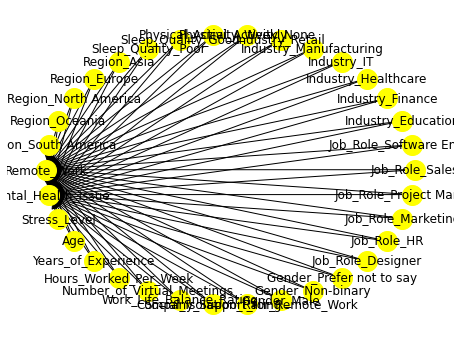

In [15]:
import pandas as pd
from dowhy import CausalModel

# Use the same preprocessed `df_final`, `Remote_Work`, and `Mental_Health_Issue`
model = CausalModel(
    data=df_final,
    treatment="Remote_Work",
    outcome="Mental_Health_Issue",
    common_causes=X.columns.tolist()
)

# Visualize DAG
model.view_model(layout="dot", file_name="causal_graph.png")


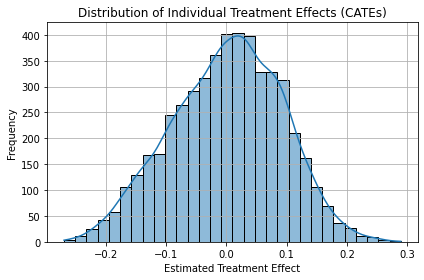

In [19]:


# Fit the DML model with RandomForestClassifier for binary treatment
dml = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)

dml.fit(Y, T, X=X)
treatment_effects = dml.effect(X)

# Save treatment effects for subgroup analysis and plotting
df_effects = df[['Gender', 'Region', 'Industry']].copy()

df_effects['CATE'] = treatment_effects

# ATE by subgroup
ate_by_gender = df_effects.groupby('Gender')['CATE'].mean()
ate_by_region = df_effects.groupby('Region')['CATE'].mean()
ate_by_industry = df_effects.groupby('Industry')['CATE'].mean()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# CATE distribution
plt.figure()
sns.histplot(treatment_effects, kde=True, bins=30)
plt.title("Distribution of Individual Treatment Effects (CATEs)")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
#plt.savefig("/mnt/data/individual_treatment_effects.png")





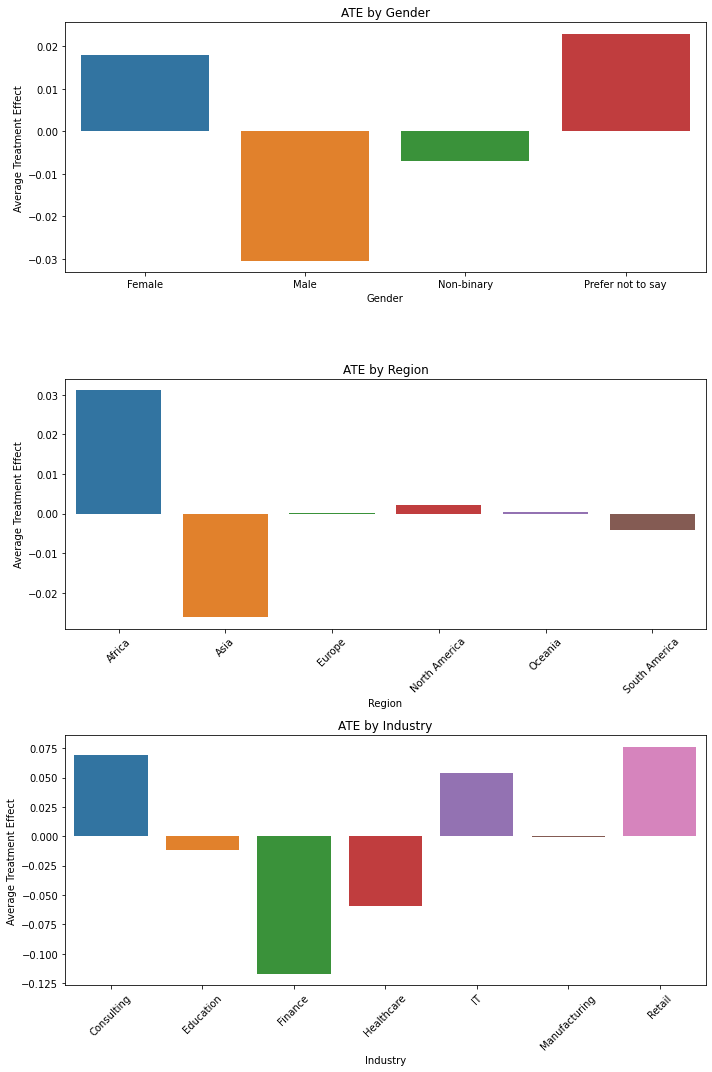

In [20]:
# ATE by subgroup
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sns.barplot(x=ate_by_gender.index, y=ate_by_gender.values, ax=axes[0])
axes[0].set_title("ATE by Gender")
axes[0].set_ylabel("Average Treatment Effect")

sns.barplot(x=ate_by_region.index, y=ate_by_region.values, ax=axes[1])
axes[1].set_title("ATE by Region")
axes[1].set_ylabel("Average Treatment Effect")
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x=ate_by_industry.index, y=ate_by_industry.values, ax=axes[2])
axes[2].set_title("ATE by Industry")
axes[2].set_ylabel("Average Treatment Effect")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
#plt.savefig("/mnt/data/ate_by_subgroup.png")



This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


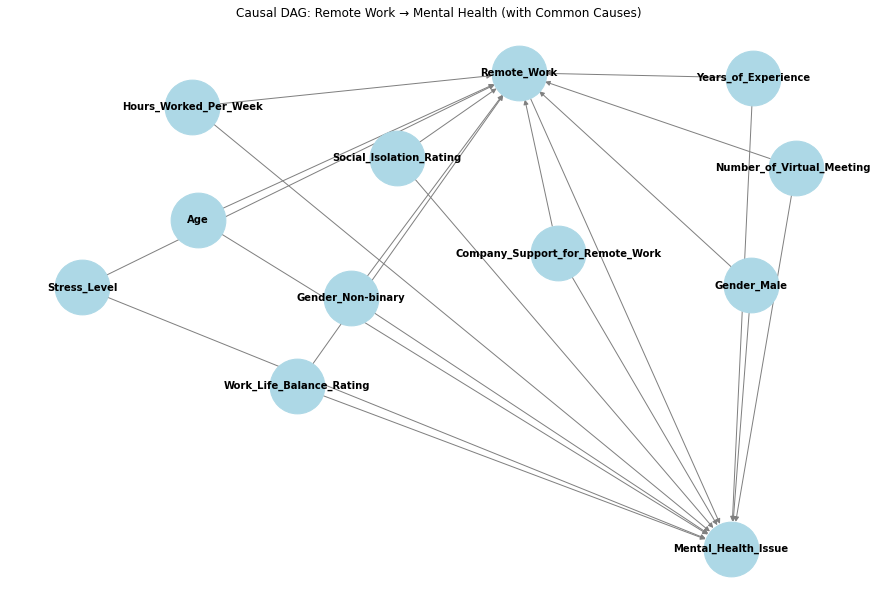

In [21]:
# Simple DAG using NetworkX
G = nx.DiGraph()
G.add_edge("Remote_Work", "Mental_Health_Issue")
for cov in X.columns[:10]:  # use only a subset for readability
    G.add_edge(cov, "Remote_Work")
    G.add_edge(cov, "Mental_Health_Issue")

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue',
        font_size=10, font_weight='bold', edge_color='gray')
plt.title("Causal DAG: Remote Work → Mental Health (with Common Causes)")
plt.tight_layout()
#plt.savefig("/mnt/data/causal_dag_graph.png")

# Return paths to generated visuals